In [2]:
import numpy as np
import torch
from torch import nn
import tqdm

In [3]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


In [4]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


#Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
# def plot_images(XX, N, title):
#     fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
#     for i in range(N):
#       for j in range(N):
#         ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
#         ax[i,j].axis("off")
#     fig.suptitle(title, fontsize=24)

# plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

    

106
12
40


In [ ]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden_dim1, hidden_dim2, dropout_rate=0.2): 
        super(ACAIGFCN, self).__init__()
        #Define the network layer(s) and activation function(s)
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        # self.dropout1 = nn.Dropout(p=dropout_rate)

        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        # self.dropout2 = nn.Dropout(p=dropout_rate)

        self.layer3 = nn.Linear(hidden_dim2, output_dim)
 
    def forward(self, input):
        #Define how your model propagates the input through the network

        out1 = self.layer1(input)
        out1 = self.batchnorm1(out1)
        out1 = nn.functional.relu(out1)
        # out1 = self.dropout1(out1)

        out2 = self.layer2(out1)
        out2 = self.batchnorm2(out2)
        out2 = nn.functional.relu(out2)
        # out2 = self.dropout2(out2)
        
        output = self.layer3(out2)
        return output


In [14]:
# Initialize neural network model with input, output and hidden layer dimensions
model = ACAIGFCN(input_dim = 784, output_dim = 10, hidden_dim1 = 128, hidden_dim2 = 64) #... add more parameters

# Initializations
# for layer in model.modules():
#     if isinstance(layer, nn.Linear):
#         nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                
# Define the learning rate and epochs number
learning_rate = 0.08
epochs = 50


train_loss_list = np.zeros((epochs,))
val_accuracy_list = np.zeros((epochs,))

# Define loss function  and optimizer
loss_func = nn.CrossEntropyLoss() # Use Cross Entropy loss from torch.nn 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Use optimizers from torch.optim


# Iterate over epochs, batches with progress bar and train+ validate the ACAIGFCN
# Track the loss and validation accuracy
for epoch in tqdm.trange(epochs):

    # ACAIGFCN Training 
    for train_features, train_labels in train_batches:
        # Set model into training mode
        model.train()
        
        # Reshape images into a vector
        train_features = train_features.reshape(-1, 28*28)

        # Reset gradients, Calculate training loss on model 
        # Perfrom optimization, back propagation
        optimizer.zero_grad()
        train_outputs = model(train_features)
        loss = loss_func(train_outputs, train_labels)
        train_loss_list[epoch] += loss.item()
        loss.backward()
        optimizer.step()
 
    # Record loss for the epoch
    
    # ACAIGFCN Validation
    for val_features, val_labels in val_batches:
        
        # Telling PyTorch we aren't passing inputs to network for training purpose
        with torch.no_grad(): 
            model.eval()
            
             # Reshape validation images into a vector
            val_features = val_features.reshape(-1, 28*28)
          
            # Compute validation outputs (targets) 
            # and compute accuracy 
            val_outputs = model(val_features)

            correct = (torch.argmax(val_outputs, dim=1) ==
                       val_labels).type(torch.FloatTensor)
            
            val_accuracy_list[epoch] = correct.mean()
        
    # Record accuracy for the epoch; print training loss, validation accuracy
    print("Epoch: "+ str(epoch) +"; Validation Accuracy:" + str(val_accuracy_list[epoch]*100) + '%')



  2%|▏         | 1/50 [00:03<02:34,  3.16s/it]

Epoch: 0; Validation Accuracy:83.423912525177%


  4%|▍         | 2/50 [00:06<02:31,  3.16s/it]

Epoch: 1; Validation Accuracy:86.6847813129425%


  6%|▌         | 3/50 [00:09<02:25,  3.10s/it]

Epoch: 2; Validation Accuracy:88.04348111152649%


  8%|▊         | 4/50 [00:12<02:20,  3.05s/it]

Epoch: 3; Validation Accuracy:87.771737575531%


 10%|█         | 5/50 [00:15<02:16,  3.03s/it]

Epoch: 4; Validation Accuracy:83.69565010070801%


 12%|█▏        | 6/50 [00:18<02:12,  3.01s/it]

Epoch: 5; Validation Accuracy:88.5869562625885%


 14%|█▍        | 7/50 [00:21<02:10,  3.04s/it]

Epoch: 6; Validation Accuracy:82.88043737411499%


 16%|█▌        | 8/50 [00:24<02:11,  3.12s/it]

Epoch: 7; Validation Accuracy:85.597825050354%


 18%|█▊        | 9/50 [00:27<02:07,  3.11s/it]

Epoch: 8; Validation Accuracy:86.95651888847351%


 20%|██        | 10/50 [00:30<02:02,  3.07s/it]

Epoch: 9; Validation Accuracy:84.5108687877655%


 22%|██▏       | 11/50 [00:33<01:57,  3.03s/it]

Epoch: 10; Validation Accuracy:84.5108687877655%


 24%|██▍       | 12/50 [00:36<01:53,  3.00s/it]

Epoch: 11; Validation Accuracy:86.1413061618805%


 26%|██▌       | 13/50 [00:39<01:50,  2.99s/it]

Epoch: 12; Validation Accuracy:89.13043737411499%


 28%|██▊       | 14/50 [00:42<01:47,  2.97s/it]

Epoch: 13; Validation Accuracy:76.902174949646%


 30%|███       | 15/50 [00:45<01:46,  3.04s/it]

Epoch: 14; Validation Accuracy:84.78260636329651%


 32%|███▏      | 16/50 [00:48<01:45,  3.09s/it]

Epoch: 15; Validation Accuracy:86.6847813129425%


 34%|███▍      | 17/50 [00:51<01:40,  3.03s/it]

Epoch: 16; Validation Accuracy:86.4130437374115%


 36%|███▌      | 18/50 [00:54<01:35,  3.00s/it]

Epoch: 17; Validation Accuracy:91.30434989929199%


 38%|███▊      | 19/50 [00:57<01:32,  2.97s/it]

Epoch: 18; Validation Accuracy:87.5%


 40%|████      | 20/50 [01:00<01:28,  2.96s/it]

Epoch: 19; Validation Accuracy:85.597825050354%


 42%|████▏     | 21/50 [01:03<01:25,  2.94s/it]

Epoch: 20; Validation Accuracy:83.96739363670349%


 44%|████▍     | 22/50 [01:06<01:22,  2.93s/it]

Epoch: 21; Validation Accuracy:90.21739363670349%


 46%|████▌     | 23/50 [01:09<01:19,  2.93s/it]

Epoch: 22; Validation Accuracy:85.326087474823%


 48%|████▊     | 24/50 [01:12<01:16,  2.95s/it]

Epoch: 23; Validation Accuracy:87.228262424469%


 50%|█████     | 25/50 [01:15<01:13,  2.94s/it]

Epoch: 24; Validation Accuracy:85.86956262588501%


 52%|█████▏    | 26/50 [01:18<01:10,  2.93s/it]

Epoch: 25; Validation Accuracy:77.44565010070801%


 54%|█████▍    | 27/50 [01:21<01:07,  2.92s/it]

Epoch: 26; Validation Accuracy:83.96739363670349%


 56%|█████▌    | 28/50 [01:23<01:04,  2.93s/it]

Epoch: 27; Validation Accuracy:89.94565010070801%


 58%|█████▊    | 29/50 [01:26<01:01,  2.92s/it]

Epoch: 28; Validation Accuracy:89.13043737411499%


 60%|██████    | 30/50 [01:29<00:58,  2.92s/it]

Epoch: 29; Validation Accuracy:85.86956262588501%


 62%|██████▏   | 31/50 [01:32<00:55,  2.92s/it]

Epoch: 30; Validation Accuracy:83.96739363670349%


 64%|██████▍   | 32/50 [01:35<00:52,  2.92s/it]

Epoch: 31; Validation Accuracy:85.326087474823%


 66%|██████▌   | 33/50 [01:38<00:50,  2.94s/it]

Epoch: 32; Validation Accuracy:88.5869562625885%


 68%|██████▊   | 34/50 [01:41<00:46,  2.93s/it]

Epoch: 33; Validation Accuracy:85.86956262588501%


 70%|███████   | 35/50 [01:44<00:43,  2.93s/it]

Epoch: 34; Validation Accuracy:90.7608687877655%


 72%|███████▏  | 36/50 [01:47<00:40,  2.92s/it]

Epoch: 35; Validation Accuracy:86.4130437374115%


 74%|███████▍  | 37/50 [01:50<00:37,  2.91s/it]

Epoch: 36; Validation Accuracy:85.05434989929199%


 76%|███████▌  | 38/50 [01:53<00:35,  2.93s/it]

Epoch: 37; Validation Accuracy:84.78260636329651%


 78%|███████▊  | 39/50 [01:56<00:32,  2.92s/it]

Epoch: 38; Validation Accuracy:88.04348111152649%


 80%|████████  | 40/50 [01:59<00:29,  2.93s/it]

Epoch: 39; Validation Accuracy:85.597825050354%


 82%|████████▏ | 41/50 [02:01<00:26,  2.93s/it]

Epoch: 40; Validation Accuracy:85.597825050354%


 84%|████████▍ | 42/50 [02:05<00:23,  2.96s/it]

Epoch: 41; Validation Accuracy:89.13043737411499%


 86%|████████▌ | 43/50 [02:08<00:21,  3.03s/it]

Epoch: 42; Validation Accuracy:85.326087474823%


 88%|████████▊ | 44/50 [02:11<00:17,  3.00s/it]

Epoch: 43; Validation Accuracy:85.326087474823%


 90%|█████████ | 45/50 [02:14<00:14,  2.97s/it]

Epoch: 44; Validation Accuracy:86.6847813129425%


 92%|█████████▏| 46/50 [02:16<00:11,  2.95s/it]

Epoch: 45; Validation Accuracy:89.13043737411499%


 94%|█████████▍| 47/50 [02:19<00:08,  2.94s/it]

Epoch: 46; Validation Accuracy:86.1413061618805%


 96%|█████████▌| 48/50 [02:22<00:05,  2.93s/it]

Epoch: 47; Validation Accuracy:86.95651888847351%


 98%|█████████▊| 49/50 [02:25<00:02,  2.93s/it]

Epoch: 48; Validation Accuracy:89.94565010070801%


100%|██████████| 50/50 [02:28<00:00,  2.97s/it]

Epoch: 49; Validation Accuracy:82.3369562625885%


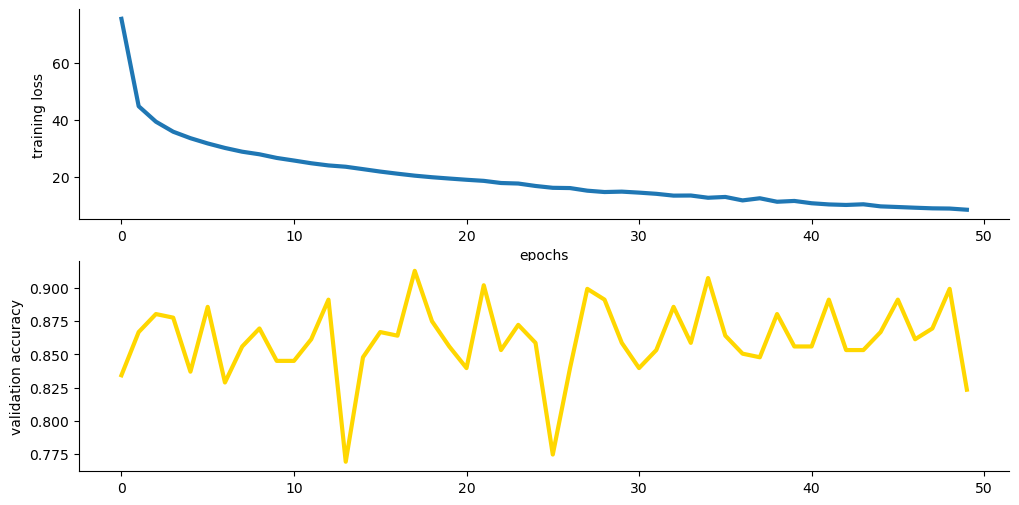

In [15]:
import seaborn as sns

# Plot training loss and validation accuracy throughout the training epochs
plt.figure(figsize = (12, 6))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")

plt.subplot(2, 1, 2)
plt.plot(val_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.grid
sns.despine()

In [16]:
#Calculate accuracy on test set
total_correct = 0
total_samples = 0

# Telling PyTorch we aren't passing inputs to network for training purpose
with torch.no_grad():
    
    for test_features, test_labels in test_batches:

        model.eval()
        # Reshape test images into a vector
        test_features = test_features.reshape(-1, 28*28)

         # Compute validation outputs (targets) 
         # and compute accuracy 
        test_outputs = model(test_features)
        predicted_labels = torch.argmax(test_outputs, dim=1)

        # Update total correct predictions
        total_correct += (predicted_labels == test_labels).sum().item()
        total_samples += test_labels.size(0)
    
    # Compute total (mean) accuracy
    # Report total (mean) accuracy, can also compute std based on batches
    test_accuracy = total_correct / total_samples
    print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")



Testing Accuracy: 82.34%


Bad pipe message: %s [b'live\r\nAccess-Control-Request-Method: GET\r\nAc', b'ss-Control-Request-Private-Network: true\r\nOrigin: https://api-57f2a007.duosecurity.com\r\nUser-Agent', b'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebK']
Bad pipe message: %s [b'/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36\r\nSec-Fetch-Mode: cors\r\nSec-Fetch-Site: cross-']
Bad pipe message: %s [b'live\r\nAccess-Control-Request-Method: GET\r\nAc', b'ss-Control-Request-Private-Network: true\r\nOrigin: https://api-57f2a007.duosecurity.com\r\nUser-Agent', b'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebK']
Bad pipe message: %s [b'/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36\r\nSec-Fetch-Mode: cors\r\nSec-Fetch-Site: cross-']
Bad pipe message: %s [b'live\r\nAccess-Control-Request-Method: GET\r\nAc', b'ss-Control-Request-Private-Network: true\r\nOrigin: https://api-57f2a007.duosecurity.com\r\nUser-Agent', b'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebK'